In [6]:
# Install required libraries (run once)
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost statsmodels tensorflow

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Load dataset
df = pd.read_csv('Sample_Traffic_Data.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)
df = df.sort_index()
df = df.drop_duplicates()
df = df[['traffic_volume']]
df = df.resample('H').mean().dropna()
df.head()

,traffic_volume
date_time,
2024-01-01 00:00:00,1719.217954
2024-01-01 01:00:00,2252.315440
2024-01-01 02:00:00,1831.886225
2024-01-01 03:00:00,2248.951136
2024-01-01 04:00:00,2319.034189


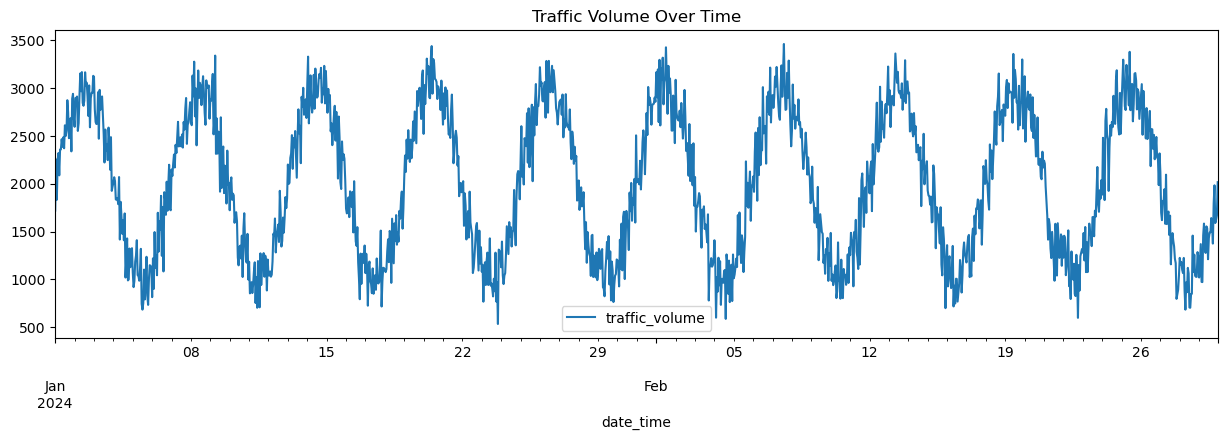

In [13]:
# Visualize
df.plot(figsize=(15,4), title='Traffic Volume Over Time');

In [14]:
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA
train, test = df['traffic_volume'][:-500], df['traffic_volume'][-500:]
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=500)

# Evaluate
print('ARIMA MAE:', mean_absolute_error(test, forecast))

ARIMA MAE: 642.3370760292266


In [15]:
# Prepare data for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['traffic_volume']])

# Create sequences
def create_seq(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 24
X, y = create_seq(scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0449
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0114
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0079
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0064
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0060


In [16]:
# Evaluate LSTM
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

print('LSTM MAE:', mean_absolute_error(y_test_inv, y_pred_inv))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
LSTM MAE: 178.16223955368218


In [17]:
# XGBoost
from xgboost import XGBRegressor

df_feat = df.copy()
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek

X = df_feat.drop('traffic_volume', axis=1)
y = df_feat['traffic_volume']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

model = XGBRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print('XGBoost MAE:', mean_absolute_error(y_test, preds))

XGBoost MAE: 658.8642876577559
